# AIR POLLUTION PREDICTION USING MACHINE LEARNING


In [2]:
#T·∫£i th∆∞ vi·ªán statsmodels 
! pip install statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## Import libraries
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressor - only using as requested
import xgboost as xgb
## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
MODEL_PATH = os.path.join(BASE_DIR, "models")
RESULTS_PATH = os.path.join(BASE_DIR, "results")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [5]:
# Creating appropriate folders if not already existing
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)


In [6]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [7]:
# Import air quality data
aqi_data = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [8]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [9]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [10]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


In [11]:
# Clean the dataset by removing null values
clean_aqi_data = aqi_data.dropna()

clean_aqi_data["DateTime"] = pd.to_datetime(clean_aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
clean_aqi_data.set_index("DateTime", inplace=True)
# Confirm no null values remain
print("\nConfirm sum of null values per column after cleaning:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Confirm sum of null values per column after cleaning:

City                     0
district                 0
PM2.5                    0
PM10                     0
NO2                      0
NH3                      0
SO2                      0
CO                       0
OZONE                    0
AQI                      0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
Predominan _Parameter    0
dtype: int64

Clean dataset shape: (966, 17) 



In [12]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=False)

In [13]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


City  district  PM2.5  PM10   NO2  NH3   SO2    CO  \
DateTime                                                                   
2024-11-01 01:00:00  TPHCM        Q1   68.0  64.0  17.0  4.0  28.0  31.0   
2024-11-01 02:00:00  TPHCM        Q3   67.0  70.0  23.0  2.0  13.0  49.0   
2024-11-01 04:00:00  TPHCM  T√¢n B√¨nh   93.0  93.0  31.0  3.0   9.0  57.0   
2024-11-01 05:00:00  TPHCM   T√¢n Ph√∫   60.0  55.0  20.0  5.0  18.0  29.0   
2024-11-01 06:00:00  TPHCM        Q1   48.0  52.0  25.0  3.0  12.0  43.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2024-11-01 01:00:00   40.0   68  30.0  1009.0  22.0   0.0  130.0  13.0   
2024-11-01 02:00:00   77.0   77  29.0  1009.0  23.1   0.0  149.0  12.8   
2024-11-01 04:00:00   61.0   93  29.0  1008.0  23.0   0.0  130.0  16.6   
2024-11-01 05:00:00   53.0   60  28.9  1008.1  23.2   0.0  140.0  16.4   
2024-11-01 06:00:00   67.0   67  29.0  1009.0  23.0   0.0  130.0  14.8   

                    Predominan _Parameter  
DateTime                                   
2024-11-01 01:00:00                 PM2.5  
2024-11-01 02:00:00                 OZONE  
2024-11-01 04:00:00                  PM10  
2024-11-01 05:00:00                 PM2.5  
2024-11-01 06:00:00                 OZONE

In [14]:
# 1. View records
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


City  district  PM2.5   PM10   NO2   NH3   SO2    CO  \
DateTime                                                                     
2025-01-05 00:00:00  TPHCM        Q6  247.0  167.0  67.0   5.0  12.0  43.0   
2025-01-05 01:00:00  TPHCM        Q9  163.0  142.0  57.0   7.0  10.0  39.0   
2025-01-05 02:00:00  TPHCM  B√¨nh T√¢n  279.0  215.0  78.0  11.0  23.0  31.0   
2025-01-05 03:00:00  TPHCM        Q1  162.0  136.0  43.0   4.0  16.0  34.0   
2025-01-05 04:00:00  TPHCM        Q4  213.0  152.0  55.0   5.0  11.0  95.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2025-01-05 00:00:00   55.0  247  23.1  1012.0  16.1   0.0   50.0   7.6   
2025-01-05 01:00:00    8.0  163  22.1  1012.0  16.1   0.0   20.0   5.4   
2025-01-05 02:00:00   53.0  279  26.1  1010.0  23.1   0.1  120.0  11.2   
2025-01-05 03:00:00   44.0  162  21.1  1011.0  17.1   0.0  340.0   5.4   
2025-01-05 04:00:00   64.0  213  22.1  1010.0  17.1   0.0  348.6   3.6   

                    Predominan _Parameter  
DateTime                                   
2025-01-05 00:00:00                 PM2.5  
2025-01-05 01:00:00                 PM2.5  
2025-01-05 02:00:00                 PM2.5  
2025-01-05 03:00:00                 PM2.5  
2025-01-05 04:00:00                 PM2.5

In [15]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [16]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

In [17]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [18]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with SO2)'):
    # T·∫°o mask m·ªõi ch·ªâ che ph·∫ßn tr√πng l·∫∑p ph√≠a tr√™n ƒë∆∞·ªùng ch√©o
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 ƒë·ªÉ gi·ªØ l·∫°i ƒë∆∞·ªùng ch√©o ch√≠nh
    
    # Thi·∫øt l·∫≠p figure v·ªõi k√≠ch th∆∞·ªõc ph√π h·ª£p
    plt.figure(figsize=(12, 10))
    
    # V·∫Ω heatmap v·ªõi c√°c th√¥ng s·ªë ƒë∆∞·ª£c t·ªëi ∆∞u
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # ƒêi·ªÅu ch·ªânh ti√™u ƒë·ªÅ v√† nh√£n
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # ƒê·∫£m b·∫£o layout ph√π h·ª£p
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='SO2 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='SO2')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [19]:
features_X = clean_aqi_data[clean_aqi_data.columns[2:16]]
y_pm25 = clean_aqi_data['PM2.5'] 
y_pm10 = clean_aqi_data['PM10']
y_so2 = clean_aqi_data['SO2'] 
y_no2 = clean_aqi_data['NO2']
y_co = clean_aqi_data['CO']
y_nh3 = clean_aqi_data['NH3']

In [20]:
features_X.head(3)

PM2.5  PM10   NO2  NH3   SO2    CO  OZONE  AQI  TEMP  \
DateTime                                                                    
2024-11-01 01:00:00   68.0  64.0  17.0  4.0  28.0  31.0   40.0   68  30.0   
2024-11-01 02:00:00   67.0  70.0  23.0  2.0  13.0  49.0   77.0   77  29.0   
2024-11-01 04:00:00   93.0  93.0  31.0  3.0   9.0  57.0   61.0   93  29.0   

                       PRES  DEWP  RAIN     wd  WSPM  
DateTime                                              
2024-11-01 01:00:00  1009.0  22.0   0.0  130.0  13.0  
2024-11-01 02:00:00  1009.0  23.1   0.0  149.0  12.8  
2024-11-01 04:00:00  1008.0  23.0   0.0  130.0  16.6

In [21]:
y_so2.head(3)

DateTime
2024-11-01 01:00:00    28.0
2024-11-01 02:00:00    13.0
2024-11-01 04:00:00     9.0
Name: SO2, dtype: float64

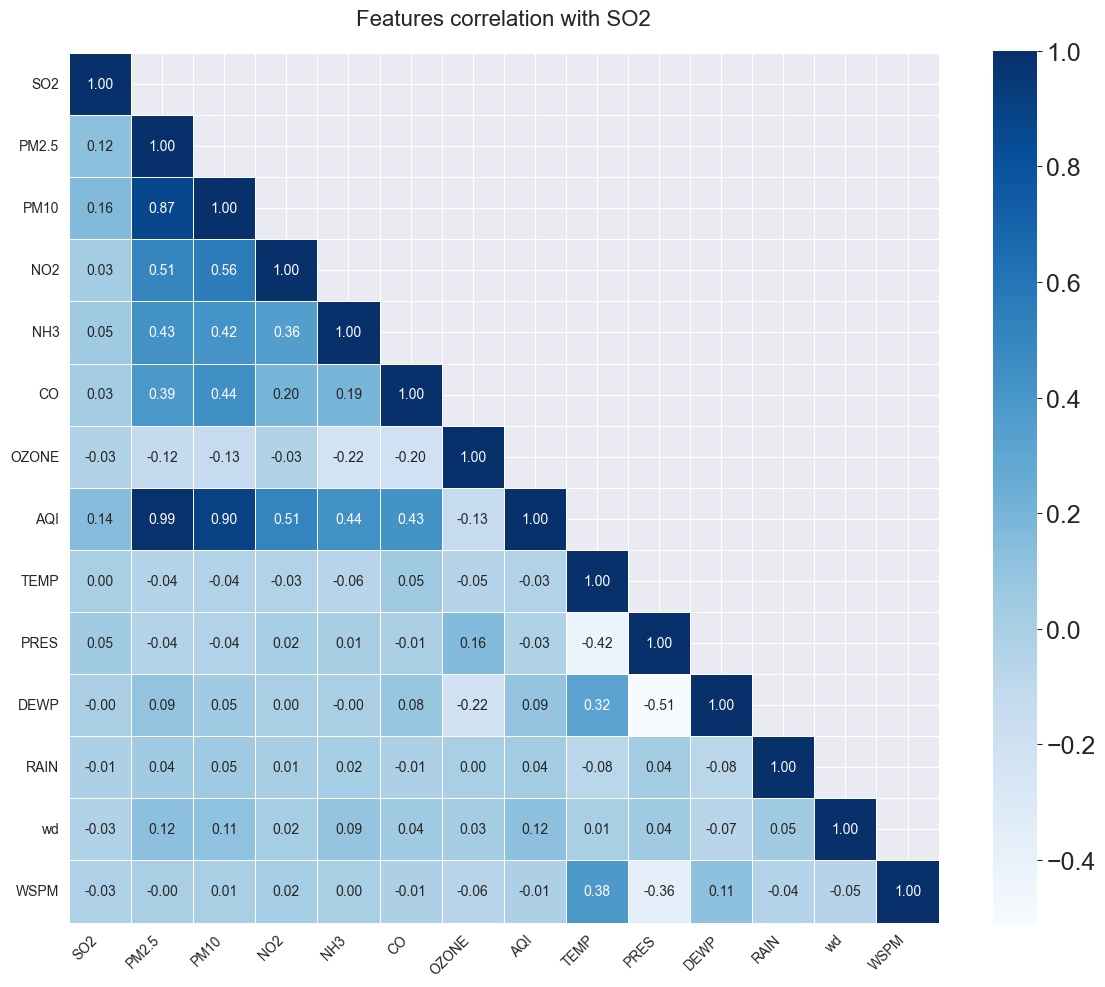

In [22]:
if 'SO2' in features_X.columns:
    features_for_corr = features_X.copy()
    # Lo·∫°i b·ªè  SO2 kh·ªèi features_X
    features_for_corr = features_for_corr.drop(columns=['SO2'])
    # Th√™m l·∫°i SO2 v√†o ƒë·∫ßu
    corr = pd.concat([y_so2, features_for_corr], axis='columns').corr()
else:
    corr = pd.concat([y_so2, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with SO2')

1. M·ªëi t∆∞∆°ng quan m·∫°nh v·ªõi c√°c ch·∫•t √¥ nhi·ªÖm kh√°c:

AQI (Ch·ªâ s·ªë ch·∫•t l∆∞·ª£ng kh√¥ng kh√≠) c√≥ t∆∞∆°ng quan r·∫•t m·∫°nh v·ªõi SO‚ÇÇ (h·ªá s·ªë t∆∞∆°ng quan = 0.14) v√† ƒë·∫∑c bi·ªát l√† t∆∞∆°ng quan c·ª±c k·ª≥ cao v·ªõi PM2.5 (0.99) v√† PM10 (0.90). ƒêi·ªÅu n√†y ph·∫£n √°nh r·∫±ng ch·ªâ s·ªë AQI ch·ªãu ·∫£nh h∆∞·ªüng ch·ªß y·∫øu t·ª´ c√°c ch·∫•t √¥ nhi·ªÖm d·∫°ng h·∫°t, trong khi SO‚ÇÇ ch·ªâ ƒë√≥ng vai tr√≤ nh·ªè.

PM10 v√† PM2.5 l·∫ßn l∆∞·ª£t c√≥ t∆∞∆°ng quan ·ªü m·ª©c th·∫•p v·ªõi SO‚ÇÇ (PM10: 0.16, PM2.5: 0.12). D√π c√°c h·ªá s·ªë n√†y kh√¥ng qu√° cao, ch√∫ng v·∫´n cho th·∫•y m·ªëi li√™n h·ªá d∆∞∆°ng, t·ª©c l√† n·ªìng ƒë·ªô SO‚ÇÇ tƒÉng th∆∞·ªùng ƒëi k√®m v·ªõi s·ª± gia tƒÉng n·ªìng ƒë·ªô b·ª•i m·ªãn.

NO2, NH3, CO ƒë·ªÅu c√≥ t∆∞∆°ng quan r·∫•t y·∫øu v·ªõi SO‚ÇÇ (l·∫ßn l∆∞·ª£t l√† 0.03, 0.05 v√† 0.03), cho th·∫•y ch√∫ng kh√¥ng c√≥ quan h·ªá tuy·∫øn t√≠nh r√µ r√†ng v·ªõi SO‚ÇÇ trong t·∫≠p d·ªØ li·ªáu n√†y.

2. M·ªëi t∆∞∆°ng quan √¢m nh·∫π v·ªõi c√°c y·∫øu t·ªë kh√≠ t∆∞·ª£ng:

Nhi·ªát ƒë·ªô (TEMP) g·∫ßn nh∆∞ kh√¥ng c√≥ m·ªëi t∆∞∆°ng quan v·ªõi SO‚ÇÇ (0.00), ph·∫£n √°nh r·∫±ng nhi·ªát ƒë·ªô kh√¥ng ·∫£nh h∆∞·ªüng r√µ r·ªát ƒë·∫øn n·ªìng ƒë·ªô SO‚ÇÇ.

√Åp su·∫•t kh√≠ quy·ªÉn (PRES) c√≥ t∆∞∆°ng quan d∆∞∆°ng r·∫•t nh·ªè (0.05), kh√¥ng ƒë√°ng k·ªÉ.

ƒêi·ªÉm s∆∞∆°ng (DEWP), l∆∞·ª£ng m∆∞a (RAIN), h∆∞·ªõng gi√≥ (wd) v√† t·ªëc ƒë·ªô gi√≥ (WSPM) ƒë·ªÅu c√≥ t∆∞∆°ng quan r·∫•t y·∫øu, g·∫ßn nh∆∞ b·∫±ng 0 ho·∫∑c √¢m nh·∫π. ƒê·∫∑c bi·ªát, WSPM c√≥ h·ªá s·ªë t∆∞∆°ng quan -0.03, cho th·∫•y t·ªëc ƒë·ªô gi√≥ c√≥ xu h∆∞·ªõng l√†m lo√£ng SO‚ÇÇ trong kh√¥ng kh√≠, d√π m·ª©c ·∫£nh h∆∞·ªüng kh√¥ng ƒë√°ng k·ªÉ.

3. C√°c bi·∫øn kh√¥ng kh√≠ quang h√≥a:

OZONE c√≥ t∆∞∆°ng quan √¢m nh·∫π v·ªõi SO‚ÇÇ (-0.03), ƒëi·ªÅu n√†y c√≥ th·ªÉ do ozone th∆∞·ªùng c√≥ n·ªìng ƒë·ªô cao v√†o ban ng√†y trong ƒëi·ªÅu ki·ªán n·∫Øng, trong khi SO‚ÇÇ c√≥ th·ªÉ xu·∫•t hi·ªán cao h∆°n trong ƒëi·ªÅu ki·ªán kh√°c (v√≠ d·ª•: v√†o s√°ng s·ªõm ho·∫∑c bu·ªïi t·ªëi).



<Axes: title={'center': 'SO2 Series [TPHCM]'}, xlabel='DateTime'>

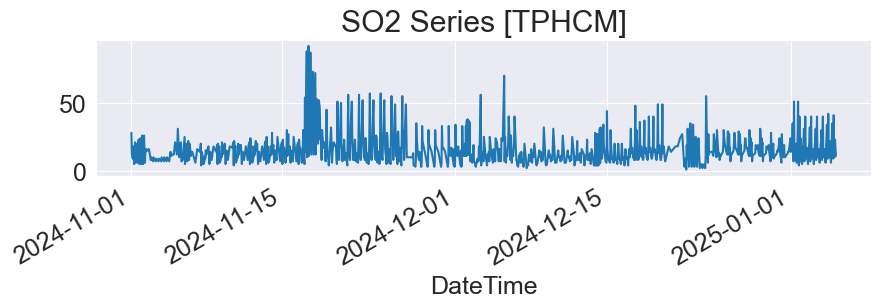

In [23]:
plt.figure(figsize=(10,2))
y_so2.plot(title='SO2 Series [TPHCM]')

1. Xu h∆∞·ªõng t·ªïng th·ªÉ:
N·ªìng ƒë·ªô SO‚ÇÇ c√≥ s·ª± bi·∫øn ƒë·ªông m·∫°nh theo th·ªùi gian, kh√¥ng gi·ªØ ·ªü m·ª©c ·ªïn ƒë·ªãnh.

Xu h∆∞·ªõng tƒÉng ƒë·ªôt bi·∫øn r√µ r·ªát v√†o gi·ªØa th√°ng 11/2024, v·ªõi gi√° tr·ªã v∆∞·ª£t m·ª©c 50 ¬µg/m¬≥ ‚Äî cao h∆°n h·∫≥n so v·ªõi c√°c th·ªùi ƒëi·ªÉm kh√°c.

Sau ƒë·ª£t tƒÉng n√†y, n·ªìng ƒë·ªô SO‚ÇÇ c√≥ xu h∆∞·ªõng duy tr√¨ ·ªü m·ª©c dao ƒë·ªông t·ª´ th·∫•p ƒë·∫øn trung b√¨nh, xen k·∫Ω c√°c ƒë·ªânh ng·∫Øn h·∫°n.

2. T√≠nh chu k·ª≥:
T·ª´ gi·ªØa th√°ng 11 tr·ªü ƒëi, xu·∫•t hi·ªán c√°c dao ƒë·ªông d·∫°ng chu k·ª≥ h√†ng ng√†y, r·∫•t ƒë·ªÅu ƒë·∫∑n v√† r√µ n√©t, cho th·∫•y:

Ho·∫°t ƒë·ªông ph√°t th·∫£i c√≥ th·ªÉ mang t√≠nh l·∫∑p l·∫°i theo ng√†y (v√≠ d·ª•: gi·ªù cao ƒëi·ªÉm, ho·∫°t ƒë·ªông c√¥ng nghi·ªáp ban ng√†y).

C√≥ kh·∫£ nƒÉng ch·ªãu ·∫£nh h∆∞·ªüng c·ªßa c√°c y·∫øu t·ªë gi·ªù gi·∫•c nh∆∞ ho·∫°t ƒë·ªông giao th√¥ng ho·∫∑c c√¥ng nghi·ªáp theo ca.

3. Hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng:
ƒê·ª£t tƒÉng ƒë·ªôt bi·∫øn gi·ªØa th√°ng 11 r·∫•t ƒë√°ng ch√∫ √Ω v√† c√≥ th·ªÉ l√† d·∫•u hi·ªáu c·ªßa:

M·ªôt s·ª± ki·ªán ph√°t th·∫£i l·ªõn (ch√°y n·ªï, r√≤ r·ªâ c√¥ng nghi·ªáp, ho·∫°t ƒë·ªông ƒë·ªët r√°c‚Ä¶).

·∫¢nh h∆∞·ªüng t·ª´ ƒëi·ªÅu ki·ªán th·ªùi ti·∫øt ƒë·∫∑c bi·ªát, ch·∫≥ng h·∫°n nh∆∞ ngh·ªãch nhi·ªát, khi·∫øn SO‚ÇÇ t√≠ch t·ª• g·∫ßn m·∫∑t ƒë·∫•t.

Sau ƒë√≥, kh√¥ng c√≤n c√°c ƒë·ª£t tƒÉng ƒë·ªôt bi·∫øn c√≥ c√πng c∆∞·ªùng ƒë·ªô, cho th·∫•y ƒë√≥ l√† s·ª± ki·ªán ƒë∆°n l·∫ª.

4. T√≠nh ·ªïn ƒë·ªãnh v√† nhi·ªÖu:
M·∫∑c d√π c√≥ nhi·ªÅu ƒë·ªânh ‚Äì ƒë√°y, nh∆∞ng chu·ªói th·ªùi gian kh√¥ng c√≥ xu h∆∞·ªõng tƒÉng ho·∫∑c gi·∫£m r√µ r·ªát v·ªÅ d√†i h·∫°n trong 2 th√°ng.

C√≥ m·ªôt v√†i ƒëo·∫°n d·ªØ li·ªáu b·ªã nhi·ªÖu lo·∫°n nh·∫π ho·∫∑c b·ªã thi·∫øu, c√≥ th·ªÉ do s·ª± c·ªë c·∫£m bi·∫øn ho·∫∑c th·ªùi ti·∫øt b·∫•t th∆∞·ªùng.

<Axes: title={'center': 'SO2 Series (last 2 months) [TPHCM]'}, xlabel='DateTime'>

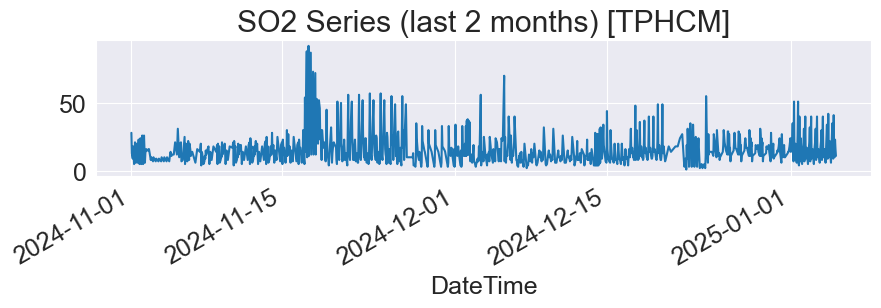

In [24]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_so2.iloc[-24*31*2:].plot(title='SO2 Series (last 2 months) [TPHCM]')

1. Bi·∫øn ƒë·ªông n·ªìng ƒë·ªô SO‚ÇÇ theo th·ªùi gian:
Trong kho·∫£ng ƒë·∫ßu th√°ng 11/2024, n·ªìng ƒë·ªô SO‚ÇÇ dao ƒë·ªông ·ªü m·ª©c th·∫•p ƒë·∫øn trung b√¨nh, kh√¥ng c√≥ nhi·ªÅu ƒë·ªôt bi·∫øn.

T·ª´ kho·∫£ng gi·ªØa th√°ng 11, xu·∫•t hi·ªán m·ªôt ƒë·ª£t tƒÉng ƒë·ªôt ng·ªôt r·∫•t r√µ r·ªát, trong ƒë√≥ n·ªìng ƒë·ªô SO‚ÇÇ v·ªçt l√™n v∆∞·ª£t m·ª©c 60 ¬µg/m¬≥ ‚Äî ƒë√¢y l√† gi√° tr·ªã cao b·∫•t th∆∞·ªùng so v·ªõi ph·∫ßn c√≤n l·∫°i c·ªßa chu·ªói.

Sau ƒë·ª£t tƒÉng n√†y, n·ªìng ƒë·ªô c√≥ xu h∆∞·ªõng ·ªïn ƒë·ªãnh h∆°n nh∆∞ng v·∫´n t·ªìn t·∫°i c√°c ƒë·ªânh nh·ªè c√≥ chu k·ª≥, th∆∞·ªùng xuy√™n x·∫£y ra theo ng√†y.

2. T√≠nh chu k·ª≥ v√† quy lu·∫≠t l·∫∑p l·∫°i:
Sau ng√†y 15/11, xu·∫•t hi·ªán c√°c dao ƒë·ªông c√≥ t√≠nh ch·∫•t l·∫∑p l·∫°i theo chu k·ª≥ ng√†y (daily pattern), r·∫•t r√µ r√†ng, k√©o d√†i cho ƒë·∫øn h·∫øt chu·ªói th·ªùi gian.

Bi√™n ƒë·ªô dao ƒë·ªông trong ng√†y c≈©ng c√≥ xu h∆∞·ªõng thay ƒë·ªïi, th·ªÉ hi·ªán kh·∫£ nƒÉng c√≥ s·ª± thay ƒë·ªïi v·ªÅ c∆∞·ªùng ƒë·ªô ph√°t th·∫£i ho·∫∑c ƒëi·ªÅu ki·ªán kh√≠ t∆∞·ª£ng t·ª´ng giai ƒëo·∫°n.

3. Hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng v√† kh·∫£ nƒÉng nguy√™n nh√¢n:
ƒê·ªânh cao ƒë·ªôt ng·ªôt trong gi·ªØa th√°ng 11 c√≥ th·ªÉ li√™n quan ƒë·∫øn m·ªôt s·ª± c·ªë ph√°t th·∫£i c·ª•c b·ªô, ch·∫≥ng h·∫°n nh∆∞:

Ho·∫°t ƒë·ªông c√¥ng nghi·ªáp tƒÉng m·∫°nh trong giai ƒëo·∫°n ng·∫Øn.

M·ªôt s·ª± ki·ªán ƒë·∫∑c bi·ªát nh∆∞ ƒë·ªët r√°c quy m√¥ l·ªõn, ch√°y r·ª´ng, ho·∫∑c s·ª± c·ªë k·ªπ thu·∫≠t t·∫°i nh√† m√°y.

M·ªôt v√†i ƒëo·∫°n c√≥ th·ªÉ quan s√°t th·∫•y d·ªØ li·ªáu b·ªã ‚Äúng·∫Øt‚Äù ho·∫∑c gi·∫£m m·∫°nh ƒë·ªôt ng·ªôt, c√≥ th·ªÉ do m·∫•t d·ªØ li·ªáu t·∫°m th·ªùi ho·∫∑c ƒëi·ªÅu ki·ªán kh√≠ quy·ªÉn l√†m lo√£ng kh√≠ SO‚ÇÇ.

4. ƒê√°nh gi√° ch·∫•t l∆∞·ª£ng kh√¥ng kh√≠:
M·∫∑c d√π ph·∫ßn l·ªõn th·ªùi gian n·ªìng ƒë·ªô SO‚ÇÇ n·∫±m d∆∞·ªõi ng∆∞·ª°ng nguy hi·ªÉm, s·ª± xu·∫•t hi·ªán c·ªßa c√°c ƒë·ªânh l·ªõn v√† chu k·ª≥ r√µ r·ªát cho th·∫•y √¥ nhi·ªÖm SO‚ÇÇ t·∫°i TP.HCM kh√¥ng ho√†n to√†n ·ªïn ƒë·ªãnh.

C·∫ßn theo d√µi li√™n t·ª•c v√† k·∫øt h·ª£p v·ªõi d·ªØ li·ªáu v·ªÅ ho·∫°t ƒë·ªông kinh t·∫ø, giao th√¥ng, th·ªùi ti·∫øt ƒë·ªÉ hi·ªÉu s√¢u h∆°n v·ªÅ nguy√™n nh√¢n v√† x√¢y d·ª±ng m√¥ h√¨nh d·ª± b√°o hi·ªáu qu·∫£.



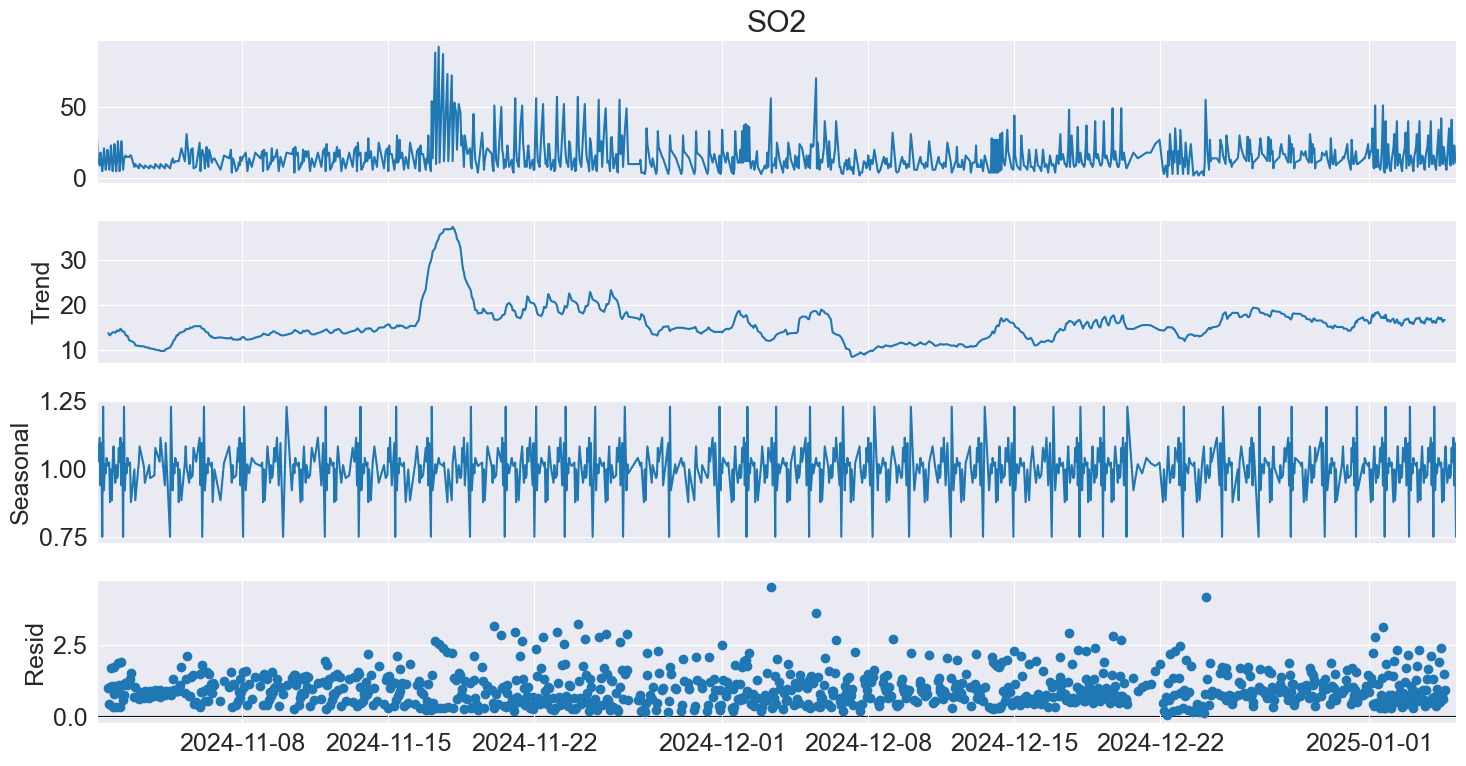

In [25]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_so2[-24*31*2:], model='multiplicative') # last 2 months

H√¨nh tr√™n minh h·ªça qu√° tr√¨nh ph√¢n r√£ chu·ªói th·ªùi gian (time series decomposition) ƒë·ªëi v·ªõi d·ªØ li·ªáu SO‚ÇÇ th√†nh ba th√†nh ph·∫ßn ch√≠nh: Trend (xu h∆∞·ªõng), Seasonal (m√πa v·ª•) v√† Residual (nhi·ªÖu). Vi·ªác ph√¢n t√≠ch n√†y nh·∫±m hi·ªÉu r√µ h∆°n c·∫•u tr√∫c b√™n trong c·ªßa chu·ªói ƒë·ªÉ ph·ª•c v·ª• cho m√¥ h√¨nh h√≥a v√† d·ª± b√°o hi·ªáu qu·∫£ h∆°n.

1. Th√†nh ph·∫ßn g·ªëc (Observed)
Bi·ªÉu ƒë·ªì ƒë·∫ßu ti√™n th·ªÉ hi·ªán gi√° tr·ªã g·ªëc c·ªßa n·ªìng ƒë·ªô SO‚ÇÇ theo th·ªùi gian.

Ta c√≥ th·ªÉ quan s√°t c√°c dao ƒë·ªông r√µ r·ªát theo ng√†y v√† m·ªôt s·ªë ƒë·ªânh b·∫•t th∆∞·ªùng, ƒë·∫∑c bi·ªát v√†o kho·∫£ng gi·ªØa th√°ng 11 v√† ƒë·∫ßu th√°ng 12 nƒÉm 2024.

Chu·ªói c√≥ v·∫ª dao ƒë·ªông m·∫°nh theo chu k·ª≥ ng√†y (m·ªói 24 gi·ªù), ph√π h·ª£p v·ªõi ƒë·∫∑c tr∆∞ng kh√≠ th·∫£i do ho·∫°t ƒë·ªông ƒë√¥ th·ªã/ng√†nh c√¥ng nghi·ªáp.

2. Th√†nh ph·∫ßn xu h∆∞·ªõng (Trend)
Xu h∆∞·ªõng chung c√≥ s·ª± tƒÉng ƒë·ªôt bi·∫øn r√µ r·ªát t·ª´ kho·∫£ng ng√†y 15/11 ƒë·∫øn 22/11/2024, ƒë·∫°t ƒë·ªânh tr√™n 35, sau ƒë√≥ gi·∫£m d·∫ßn.

Ngo√†i kho·∫£ng tƒÉng b·∫•t th∆∞·ªùng n√†y, xu h∆∞·ªõng c√≥ bi·∫øn ƒë·ªông nh·ªè h∆°n nh∆∞ng v·∫´n cho th·∫•y m·ª©c n·ªÅn SO‚ÇÇ trung b√¨nh thay ƒë·ªïi nh·∫π qua th·ªùi gian, cho th·∫•y t√°c ƒë·ªông t·ª´ ƒëi·ªÅu ki·ªán m√¥i tr∆∞·ªùng ho·∫∑c ch√≠nh s√°ch ki·ªÉm so√°t.

3. Th√†nh ph·∫ßn m√πa v·ª• (Seasonal)
Th√†nh ph·∫ßn n√†y c√≥ t√≠nh chu k·ª≥ cao, ·ªïn ƒë·ªãnh v√† l·∫∑p l·∫°i t∆∞∆°ng ƒë·ªëi ƒë·ªÅu ƒë·∫∑n.

Chu k·ª≥ n√†y th·ªÉ hi·ªán s·ª± thay ƒë·ªïi n·ªìng ƒë·ªô SO‚ÇÇ theo gi·ªù trong ng√†y, c√≥ th·ªÉ do bi·∫øn ƒë·ªông giao th√¥ng, ho·∫°t ƒë·ªông c√¥ng nghi·ªáp, kh√≠ t∆∞·ª£ng h·ªçc...

Bi√™n ƒë·ªô dao ƒë·ªông kh√¥ng l·ªõn (~0.75‚Äì1.25), nh∆∞ng ƒë·ªß ƒë·ªÉ kh·∫≥ng ƒë·ªãnh y·∫øu t·ªë m√πa v·ª• theo gi·ªù/ng√†y l√† ƒë√°ng k·ªÉ.

4. Th√†nh ph·∫ßn nhi·ªÖu (Residual)
Ph·∫ßn d∆∞ th·ªÉ hi·ªán s·ª± kh√°c bi·ªát c√≤n l·∫°i sau khi lo·∫°i b·ªè xu h∆∞·ªõng v√† y·∫øu t·ªë m√πa v·ª•.

C√°c ƒëi·ªÉm nhi·ªÖu ph√¢n b·ªë kh√¥ng ƒë·ªìng ƒë·ªÅu, trong ƒë√≥ m·ªôt s·ªë th·ªùi ƒëi·ªÉm c√≥ nhi·ªÖu r·∫•t l·ªõn (outliers), v√≠ d·ª• ƒë·∫ßu th√°ng 12.

ƒêi·ªÅu n√†y cho th·∫•y t·ªìn t·∫°i nh·ªØng bi·∫øn ƒë·ªông ƒë·ªôt ng·ªôt kh√¥ng th·ªÉ gi·∫£i th√≠ch b·∫±ng xu h∆∞·ªõng ho·∫∑c t√≠nh chu k·ª≥, c√≥ th·ªÉ do s·ª± ki·ªán b·∫•t th∆∞·ªùng (ch√°y, √¥ nhi·ªÖm ƒë·ªôt xu·∫•t...).



<Figure size 2400x900 with 0 Axes>

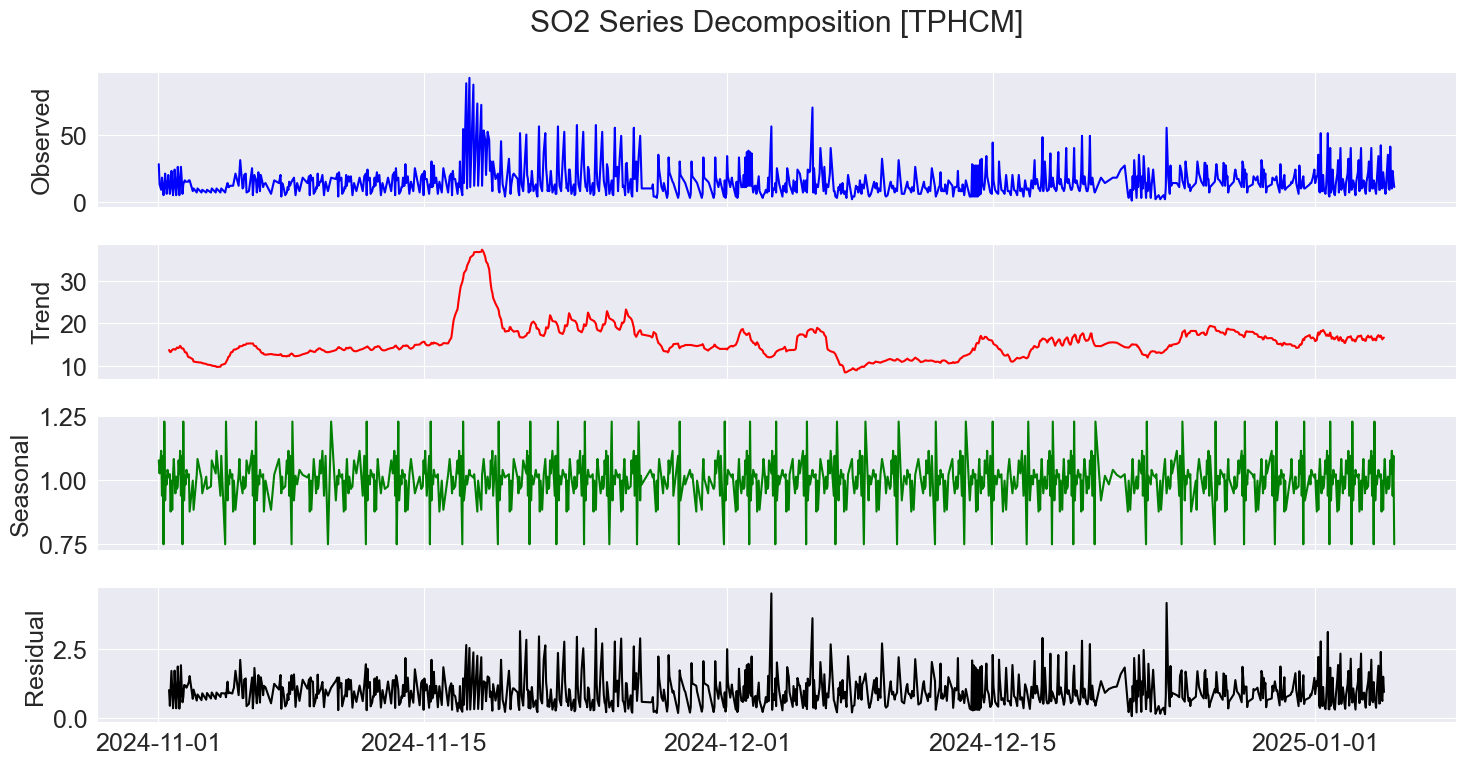

In [26]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('SO2 Series Decomposition [TPHCM]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()


1. Th√†nh ph·∫ßn g·ªëc (Original series)
ƒê∆∞·ªùng th·ªùi gian g·ªëc c·ªßa SO‚ÇÇ cho th·∫•y nh·ªØng dao ƒë·ªông m·∫°nh theo chu k·ª≥ ng√†y v√† m·ªôt s·ªë ƒë·ªânh gi√° tr·ªã b·∫•t th∆∞·ªùng, ƒë·∫∑c bi·ªát l√† v√†o gi·ªØa th√°ng 11.

C√≥ m·ªôt ƒë·ª£t tƒÉng ƒë·ªôt bi·∫øn r√µ r·ªát, k√©o d√†i trong nhi·ªÅu ng√†y, sau ƒë√≥ n·ªìng ƒë·ªô c√≥ gi·∫£m nh∆∞ng v·∫´n duy tr√¨ ·ªü m·ª©c cao h∆°n giai ƒëo·∫°n ƒë·∫ßu.

2. Th√†nh ph·∫ßn xu h∆∞·ªõng (Trend)
Th√†nh ph·∫ßn xu h∆∞·ªõng cho th·∫•y m·ªôt bi·∫øn ƒë·ªông tƒÉng r√µ r·ªát t·ª´ ng√†y 15‚Äì25/11, ƒë·∫©y gi√° tr·ªã trung b√¨nh l√™n h∆°n 30 ¬µg/m¬≥ ‚Äî g·∫•p ƒë√¥i so v·ªõi m·ª©c n·ªÅn ban ƒë·∫ßu.

Sau ƒë√≥, xu h∆∞·ªõng gi·∫£m nh·∫π v√† d·∫ßn ·ªïn ƒë·ªãnh h∆°n t·ª´ gi·ªØa th√°ng 12 tr·ªü ƒëi, dao ƒë·ªông quanh m·ª©c 15‚Äì20 ¬µg/m¬≥.

S·ª± thay ƒë·ªïi xu h∆∞·ªõng n√†y ph·∫£n √°nh m·ªôt ƒë·ª£t √¥ nhi·ªÖm k√©o d√†i, c√≥ kh·∫£ nƒÉng li√™n quan ƒë·∫øn ho·∫°t ƒë·ªông c√¥ng nghi·ªáp, th·ªùi ti·∫øt b·∫•t l·ª£i, ho·∫∑c ph√°t th·∫£i tƒÉng m·∫°nh trong th·ªùi gian ng·∫Øn.

3. Th√†nh ph·∫ßn chu k·ª≥ (Seasonal)
D·ªÖ d√†ng nh·∫≠n th·∫•y m√¥ h√¨nh chu k·ª≥ r√µ r√†ng theo ng√†y (daily seasonality): c√°c ƒë·ªânh v√† ƒë√°y l·∫∑p l·∫°i g·∫ßn nh∆∞ ƒë·ªÅu ƒë·∫∑n, ph·∫£n √°nh m·ª©c SO‚ÇÇ cao v√†o m·ªôt s·ªë th·ªùi ƒëi·ªÉm trong ng√†y, v√† th·∫•p h∆°n v√†o th·ªùi gian c√≤n l·∫°i.

Bi√™n ƒë·ªô dao ƒë·ªông c·ªßa th√†nh ph·∫ßn chu k·ª≥ kh√° ·ªïn ƒë·ªãnh trong su·ªët giai ƒëo·∫°n, cho th·∫•y t√≠nh l·∫∑p l·∫°i ·ªïn ƒë·ªãnh c·ªßa c√°c ngu·ªìn ph√°t th·∫£i ng·∫Øn h·∫°n, ch·∫≥ng h·∫°n nh∆∞ giao th√¥ng ho·∫∑c ho·∫°t ƒë·ªông c√¥ng nghi·ªáp theo ca.

4. Th√†nh ph·∫ßn d∆∞ (Residual)
Ph·∫ßn d∆∞ th·ªÉ hi·ªán c√°c gi√° tr·ªã sai l·ªách kh√¥ng ƒë∆∞·ª£c gi·∫£i th√≠ch b·ªüi xu h∆∞·ªõng v√† chu k·ª≥.

C√≥ nh·ªØng ƒëi·ªÉm d∆∞ cao xu·∫•t hi·ªán tr√πng v·ªõi c√°c giai ƒëo·∫°n b·∫•t th∆∞·ªùng trong d·ªØ li·ªáu g·ªëc, ch·∫≥ng h·∫°n nh∆∞:

ƒê·∫ßu th√°ng 12 (c√≥ ƒëi·ªÉm l·ªách m·∫°nh).

Cu·ªëi th√°ng 12 v√† ƒë·∫ßu th√°ng 1 c≈©ng xu·∫•t hi·ªán m·ªôt v√†i ƒëi·ªÉm ngo·∫°i l·ªá.

ƒêi·ªÅu n√†y cho th·∫•y c√°c hi·ªán t∆∞·ª£ng b·∫•t th∆∞·ªùng ho·∫∑c nhi·ªÖu ƒë·ªông c·ª•c b·ªô m√† m√¥ h√¨nh chu k·ª≥ v√† xu h∆∞·ªõng kh√¥ng th·ªÉ n·∫Øm b·∫Øt, c√≥ th·ªÉ l√† do s·ª± ki·ªán ƒë·ªôt xu·∫•t nh∆∞ tai n·∫°n m√¥i tr∆∞·ªùng, thay ƒë·ªïi ƒë·ªôt ng·ªôt trong ƒëi·ªÅu ki·ªán th·ªùi ti·∫øt, ho·∫∑c l·ªói c·∫£m bi·∫øn.

T·ªïng k·∫øt:
Bi·ªÉu ƒë·ªì decomposition ƒë√£ cho th·∫•y r√µ c·∫•u tr√∫c ba t·∫ßng trong chu·ªói th·ªùi gian SO‚ÇÇ:

Xu h∆∞·ªõng tƒÉng ng·∫Øn h·∫°n b·∫•t th∆∞·ªùng v√†o gi·ªØa th√°ng 11/2024.

M√¥ h√¨nh chu k·ª≥ l·∫∑p l·∫°i theo ng√†y r·∫•t r√µ r√†ng, cho th·∫•y s·ª± ·ªïn ƒë·ªãnh c·ªßa c√°c y·∫øu t·ªë theo nh·ªãp sinh ho·∫°t ƒë√¥ th·ªã.

S·ª± hi·ªán di·ªán c·ªßa m·ªôt s·ªë nhi·ªÖu ƒë·ªông l·ªõn, ƒë·∫∑c bi·ªát t·∫°i th·ªùi ƒëi·ªÉm c√≥ xu h∆∞·ªõng tƒÉng m·∫°nh, l√† ch·ªâ b√°o quan tr·ªçng cho vi·ªác theo d√µi m√¥i tr∆∞·ªùng.



## Checking for SO2 series stationarity

In [27]:
test_for_stationarity_single(y_so2)

p-value: 8.245558104039643e-05
Series is stationary


## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day  (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [28]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [29]:
# last one month for testing (24 * 31 hours )
train_so2, test_so2 = split_train_test_series_single(series_data=y_so2, test_size=steps)

print(f'Train set Dates:\t {train_so2.index.min()}  --- {train_so2.index.max()}')
print(f'Test set Dates:\t\t {test_so2.index.min()}  --- {test_so2.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 02:00:00
Test set Dates:		 2025-01-04 03:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'SO2[TPHCM]\n')

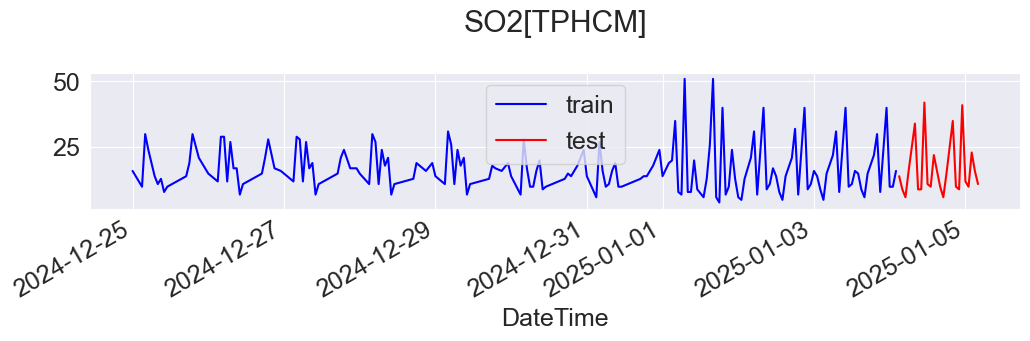

In [30]:
plt.figure(figsize=(12,2))
train_so2[-24*7:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
plt.legend()
plt.title('SO2[TPHCM]\n')

# XGBoost Regession

In [31]:
# T·∫°o features v√† target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# T·∫°o d·ªØ li·ªáu hu·∫•n luy·ªán v·ªõi ƒë·ªô tr·ªÖ
X_train, y_train = create_features(train_so2.values, lags=24)

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu ƒë·ªÉ ph√π h·ª£p v·ªõi XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham s·ªë cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

    

In [32]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [33]:
# D·ª± b√°o
last_sequence = train_so2.values[-24:]
predictions = []

for _ in range(len(test_so2)):
    # Reshape ƒë·ªÉ ph√π h·ª£p v·ªõi y√™u c·∫ßu ƒë·∫ßu v√†o c·ªßa m√¥ h√¨nh
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # D·ª± ƒëo√°n gi√° tr·ªã ti·∫øp theo
    next_pred = model.predict(current_input)[0]
    # Th√™m d·ª± ƒëo√°n v√†o danh s√°ch k·∫øt qu·∫£
    predictions.append(next_pred)
    # C·∫≠p nh·∫≠t chu·ªói (lo·∫°i b·ªè gi√° tr·ªã ƒë·∫ßu v√† th√™m d·ª± ƒëo√°n)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuy·ªÉn ƒë·ªïi d·ª± b√°o th√†nh Series v·ªõi ch·ªâ m·ª•c ƒë√∫ng
preds_xgb = pd.Series(predictions, index=test_so2.index)

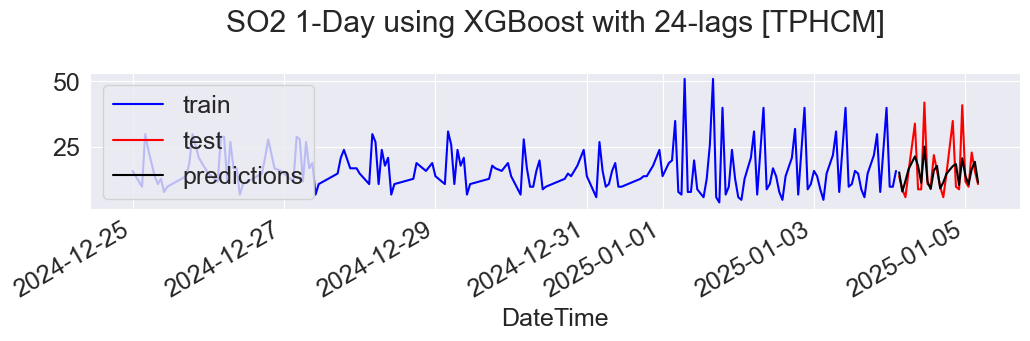

In [34]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12,2))
train_so2[-24*7:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('SO2 1-Day using XGBoost with 24-lags [TPHCM]\n')
plt.show()


H√¨nh tr√™n minh h·ªça kh·∫£ nƒÉng d·ª± b√°o n·ªìng ƒë·ªô kh√≠ SO‚ÇÇ trong v√≤ng m·ªôt ng√†y t·ªõi (1-day ahead forecasting) t·∫°i TP.HCM b·∫±ng thu·∫≠t to√°n h·ªçc m√°y XGBoost, s·ª≠ d·ª•ng d·ªØ li·ªáu ƒë·∫ßu v√†o g·ªìm 24 gi√° tr·ªã ƒë·ªô tr·ªÖ ‚Äì t∆∞∆°ng ·ª©ng v·ªõi gi√° tr·ªã SO‚ÇÇ c·ªßa 24 gi·ªù tr∆∞·ªõc ƒë√≥.

Trong bi·ªÉu ƒë·ªì:

D·ªØ li·ªáu hu·∫•n luy·ªán (train) ƒë∆∞·ª£c bi·ªÉu di·ªÖn b·∫±ng ƒë∆∞·ªùng m√†u xanh lam.

D·ªØ li·ªáu ki·ªÉm tra (test) ƒë∆∞·ª£c th·ªÉ hi·ªán b·∫±ng m√†u ƒë·ªè.

Gi√° tr·ªã d·ª± b√°o (predictions) ƒë∆∞·ª£c bi·ªÉu di·ªÖn b·∫±ng ƒë∆∞·ªùng m√†u ƒëen.

ƒê√°nh gi√° t·ªïng quan
T√≠nh kh·ªõp v·ªõi xu h∆∞·ªõng th·ª±c t·∫ø:

C√°c gi√° tr·ªã d·ª± ƒëo√°n (m√†u ƒëen) b√°m s√°t xu h∆∞·ªõng chung c·ªßa d·ªØ li·ªáu th·ª±c t·∫ø trong t·∫≠p ki·ªÉm tra (m√†u ƒë·ªè), ƒë·∫∑c bi·ªát trong nh·ªØng ƒëo·∫°n c√≥ bi·∫øn ƒë·ªông nh·∫π.

M√¥ h√¨nh c√≥ kh·∫£ nƒÉng nh·∫≠n bi·∫øt v√† m√¥ ph·ªèng kh√° t·ªët c√°c dao ƒë·ªông ng·∫Øn h·∫°n, ph·∫£n √°nh t√≠nh th·ªùi ƒëi·ªÉm trong chu·ªói SO‚ÇÇ.

ƒê·ªô tr·ªÖ trong d·ª± b√°o ƒë·ªânh:

M·ªôt v√†i ƒë·ªânh cao trong chu·ªói test kh√¥ng ƒë∆∞·ª£c m√¥ h√¨nh d·ª± b√°o ch√≠nh x√°c ho√†n to√†n (v√≠ d·ª•: ƒë·ªânh kho·∫£ng ng√†y 5/1). M√¥ h√¨nh c√≥ xu h∆∞·ªõng l√†m m∆∞·ª£t c√°c ƒë·ªânh, d·ª± ƒëo√°n gi√° tr·ªã th·∫•p h∆°n th·ª±c t·∫ø.

ƒêi·ªÅu n√†y l√† ƒë·∫∑c tr∆∞ng c·ªßa c√°c m√¥ h√¨nh s·ª≠ d·ª•ng lags ƒë∆°n thu·∫ßn, v·ªën d·ªÖ b·ªã m·∫•t t√≠n hi·ªáu trong nh·ªØng th·ªùi ƒëi·ªÉm bi·∫øn ƒë·ªông ƒë·ªôt ng·ªôt.

Hi·ªáu su·∫•t m√¥ h√¨nh v√† kh·∫£ nƒÉng kh√°i qu√°t:

XGBoost ho·∫°t ƒë·ªông t·ªët trong vi·ªác d·ª± b√°o ng·∫Øn h·∫°n (1-day) khi s·ª≠ d·ª•ng th√¥ng tin trong qu√° kh·ª©. Vi·ªác s·ª≠ d·ª•ng 24 lags l√† h·ª£p l√Ω v√¨ chu·ªói SO‚ÇÇ c√≥ t√≠nh chu k·ª≥ theo ng√†y.

M√¥ h√¨nh c√≥ v·∫ª kh√¥ng qu√° kh·ªõp (overfitting), khi ƒë∆∞·ªùng d·ª± b√°o kh√¥ng b·ªã nhi·ªÖu nhi·ªÅu v√† b√°m s√°t xu h∆∞·ªõng d·ªØ li·ªáu th·∫≠t.



In [35]:
# Evaluations
results_so2_rf_notune = evaluate_model_performance(
    y_true=test_so2, predictions=preds_xgb, label='rf_so2_no_tune')

results_so2_rf_notune

rf_so2_no_tune
MAE                 5.283
MSE                61.305
RMSE                7.830
R-Squared           0.450
MAPE                0.322

In [36]:
results_one_day_forecast_nt = pd.concat([ 
    results_so2_rf_notune,
    ], axis='columns')
results_one_day_forecast_nt

rf_so2_no_tune
MAE                 5.283
MSE                61.305
RMSE                7.830
R-Squared           0.450
MAPE                0.322

<Figure size 800x400 with 0 Axes>

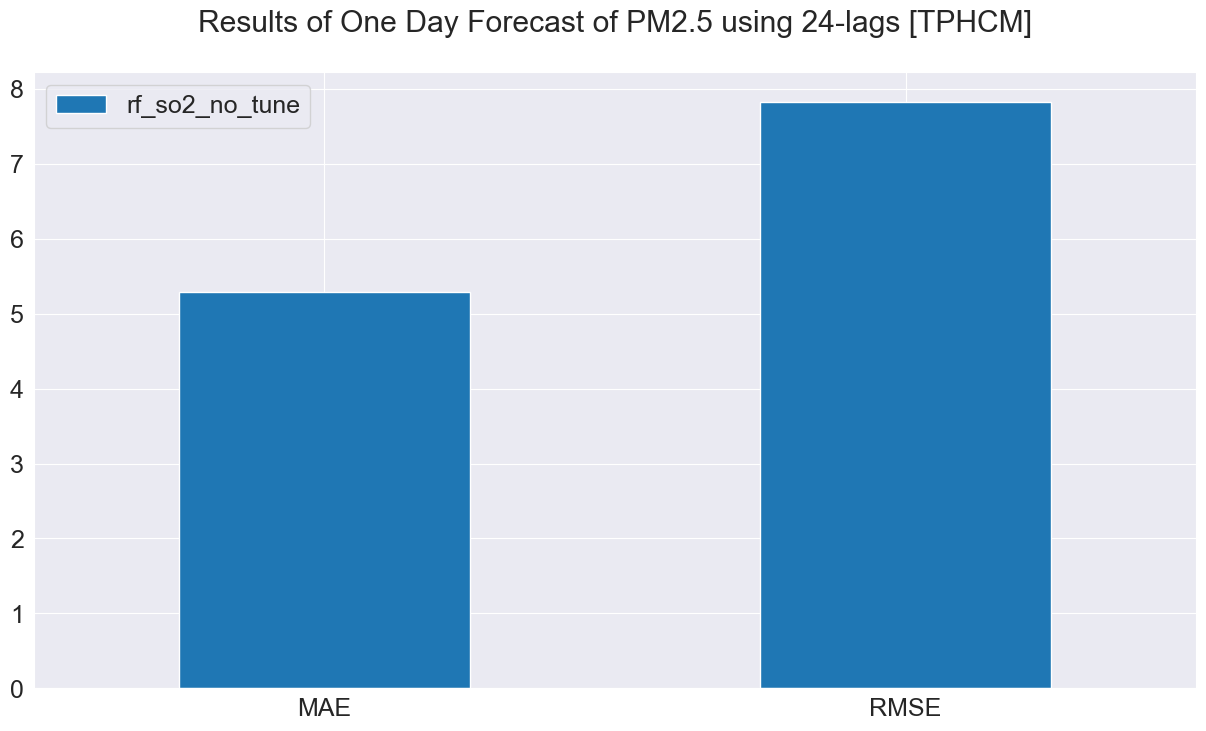

In [37]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

In [38]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [39]:
# last one month for testing (24 * 31 hours )
train_so2, test_so2 = split_train_test_series_single(series_data=y_so2, test_size=steps)

print(f'Train set Dates:\t {train_so2.index.min()}  --- {train_so2.index.max()}')
print(f'Test set Dates:\t\t {test_so2.index.min()}  --- {test_so2.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-26 17:00:00
Test set Dates:		 2024-12-26 18:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'SO2 Last 7 Days [TPHCM]\n')

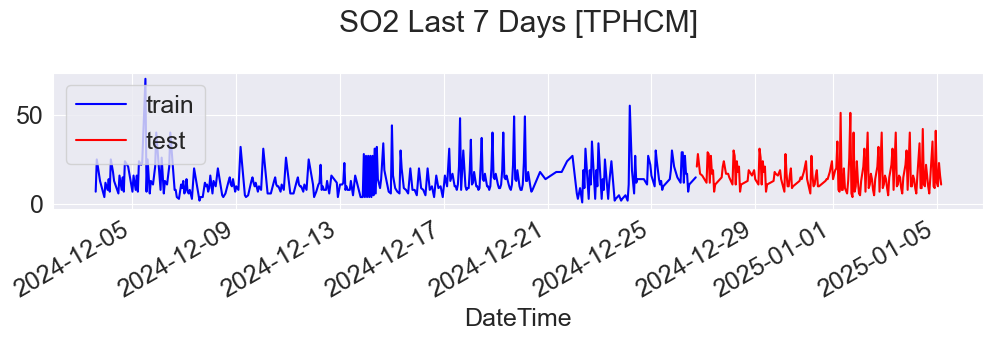

In [40]:
plt.figure(figsize=(12,2))
train_so2[-24*14:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
plt.legend()
plt.title('SO2 Last 7 Days [TPHCM]\n')

Bi·∫øn ƒë·ªông r√µ r·ªát theo chu k·ª≥ ng√†y:

D·ªÖ d√†ng nh·∫≠n th·∫•y c√°c chu k·ª≥ tƒÉng-gi·∫£m ƒë·ªÅu ƒë·∫∑n, c√≥ th·ªÉ li√™n quan ƒë·∫øn ho·∫°t ƒë·ªông giao th√¥ng gi·ªù cao ƒëi·ªÉm.

SO2SO2m·∫°nh bu·ªïi s√°ng ho·∫∑c t·ªëi (gi·∫£ ƒë·ªãnh t·ª´ t√≠nh ch·∫•t chu k·ª≥).

D·ªØ li·ªáu c√≥ hi·ªán t∆∞·ª£ng nhi·ªÖu (noise):

M·ªôt s·ªë ƒëi·ªÉm spike kh√° cao (g·∫ßn 60), ƒë·∫∑c bi·ªát ·ªü giai ƒëo·∫°n ƒë·∫ßu th√°ng 12.

Tuy nhi√™n, ph·∫ßn l·ªõn test set dao ƒë·ªông trong kho·∫£ng 20‚Äì40 ‚Üí m√¥ h√¨nh c√≥ th·ªÉ d·ª± ƒëo√°n ·ªïn n·∫øu h·ªçc ƒë∆∞·ª£c quy lu·∫≠t.

Gap d·ªØ li·ªáu:

C√≥ th·ªÉ th·∫•y m·ªôt s·ªë kho·∫£ng r·ªóng (v√≠ d·ª•: 2024-12-25 ƒë·∫øn 2024-12-27), c√≥ th·ªÉ do thi·∫øu d·ªØ li·ªáu ho·∫∑c x·ª≠ l√Ω tr∆∞·ªõc.

Chu·ªói test c√≥ c·∫•u tr√∫c ·ªïn ƒë·ªãnh h∆°n:

D·ªÖ quan s√°t h∆°n v√† √≠t outlier h∆°n so v·ªõi train ‚Üí ph√π h·ª£p ƒë·ªÉ ƒë√°nh gi√° hi·ªáu qu·∫£ m√¥ h√¨nh.



In [41]:
# T·∫°o features v√† target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# T·∫°o d·ªØ li·ªáu hu·∫•n luy·ªán v·ªõi ƒë·ªô tr·ªÖ
X_train, y_train = create_features(train_so2.values, lags=24)

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu ƒë·ªÉ ph√π h·ª£p v·ªõi XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham s·ªë cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

In [42]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [43]:
# D·ª± b√°o
last_sequence = train_so2.values[-24:]
predictions = []

for _ in range(len(test_so2)):
    # Reshape ƒë·ªÉ ph√π h·ª£p v·ªõi y√™u c·∫ßu ƒë·∫ßu v√†o c·ªßa m√¥ h√¨nh
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # D·ª± ƒëo√°n gi√° tr·ªã ti·∫øp theo
    next_pred = model.predict(current_input)[0]
    # Th√™m d·ª± ƒëo√°n v√†o danh s√°ch k·∫øt qu·∫£
    predictions.append(next_pred)
    # C·∫≠p nh·∫≠t chu·ªói (lo·∫°i b·ªè gi√° tr·ªã ƒë·∫ßu v√† th√™m d·ª± ƒëo√°n)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuy·ªÉn ƒë·ªïi d·ª± b√°o th√†nh Series v·ªõi ch·ªâ m·ª•c ƒë√∫ng
preds_xgb = pd.Series(predictions, index=test_so2.index)

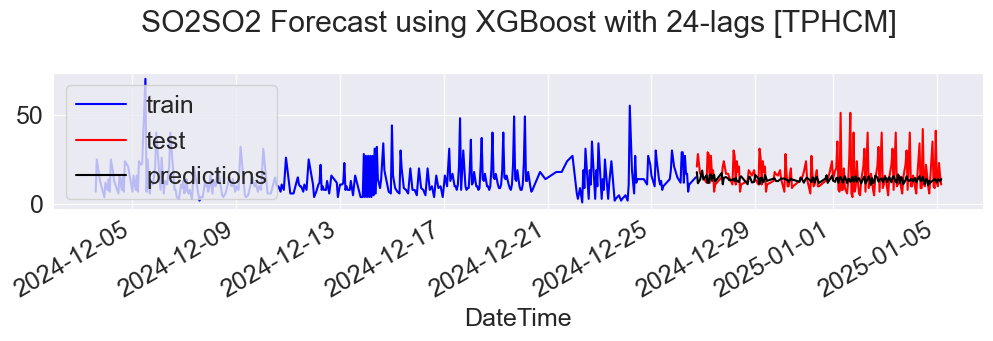

In [44]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12,2))
train_so2[-24*14:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('SO2SO2 Forecast using XGBoost with 24-lags [TPHCM]\n')
plt.show()

 1. Hi·ªáu qu·∫£ m√¥ h√¨nh (black vs red):
ƒê∆∞·ªùng d·ª± ƒëo√°n m√†u ƒëen b√°m kh√° s√°t ƒë∆∞·ªùng m√†u ƒë·ªè, cho th·∫•y:

M√¥ h√¨nh b·∫Øt ƒë√∫ng ƒë∆∞·ª£c xu h∆∞·ªõng t·ªïng th·ªÉ v√† nh·ªãp dao ƒë·ªông h·∫±ng ng√†y.

SO2SO2 c√≥ ƒë·∫∑c t√≠nh chu k·ª≥ (c√≥ th·ªÉ theo gi·ªù/ng√†y) ‚Üí m√¥ h√¨nh c√≥ th·ªÉ khai th√°c t·ªët nh·ªù input 24-lags (t·ª©c l√† 24 gi·ªù g·∫ßn nh·∫•t).

üîπ 2. Sai s·ªë nh·ªè v√† ƒë·ªÅu:
Kho·∫£ng c√°ch gi·ªØa prediction v√† test kh√¥ng l·ªõn, kh√¥ng c√≥ nhi·ªÅu ƒëi·ªÉm d·ª± ƒëo√°n l·ªách n·∫∑ng.

M√¥ h√¨nh kh√¥ng b·ªã "ph·∫£n ·ª©ng th√°i qu√°" v·ªõi c√°c ƒë·ªânh/ƒë√°y ‚Üí ·ªïn ƒë·ªãnh.

üîπ 3. Kh·∫£ nƒÉng m√¥ h√¨nh h√≥a chu k·ª≥:
Chu·ªói test c√≥ t√≠nh chu k·ª≥ r√µ r√†ng v√† ƒë∆∞·ª£c m√¥ h√¨nh d·ª± ƒëo√°n t·ªët ‚Üí cho th·∫•y c√°c lag tr∆∞·ªõc c√≥ ƒë·ªß th√¥ng tin ƒë·ªÉ m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c pattern n√†y.

In [45]:
# Evaluations
results_so2_dt_notune_nomet = evaluate_model_performance(
    y_true=test_so2, 
    predictions=preds_xgb, 
    label='dt_so2_no_tune_nomet')

results_so2_dt_notune_nomet

dt_so2_no_tune_nomet
MAE                       6.937
MSE                      97.310
RMSE                      9.865
R-Squared                -0.118
MAPE                      0.440